In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import gaussian_kde

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.verification import load_tganom_and_compute, load_tgex_and_compute, build_fit_nn_model, compute_bss, compute_kss, compute_auc, reduce_to_ranks

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import reliability_plot

2022-01-05 16:38:15.683117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-05 16:38:15.683137: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Investigation of most successful prediction
(When going through the standard objective predictor selection).

In [2]:
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
total, test_only = build_fit_nn_model(predictandname = name, npreds = 4, use_jmeasure=False)
trainval_only = total.drop(test_only.index, axis = 0)

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200


2022-01-05 16:38:51.984571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-05 16:38:51.984607: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-05 16:38:51.984629: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104.dynamic.knmi.nl): /proc/driver/nvidia/version does not exist
2022-01-05 16:38:51.984833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-05 16:38:52.152396: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None o

41/41 [==============================] - 0s 4ms/step - loss: 0.7262 - accuracy: 0.5498 - brier: 0.2599 - val_loss: 0.7864 - val_accuracy: 0.4826 - val_brier: 0.2893
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7227 - accuracy: 0.5498 - brier: 0.2581 - val_loss: 0.7836 - val_accuracy: 0.4826 - val_brier: 0.2882
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7187 - accuracy: 0.5855 - brier: 0.2560 - val_loss: 0.7802 - val_accuracy: 0.4905 - val_brier: 0.2869
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7123 - accuracy: 0.5832 - brier: 0.2532 - val_loss: 0.7760 - val_accuracy: 0.4921 - val_brier: 0.2852
Epoch 5/200
41/41 [==============================] - 0s 998us/step - loss: 0.7018 - accuracy: 0.6011 - brier: 0.2482 - val_loss: 0.7698 - val_accuracy: 0.5016 - val_brier: 0.2826
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6897 - accuracy: 0.5972 - brier: 0.2428 - val_loss

41/41 [==============================] - 0s 1ms/step - loss: 0.5323 - accuracy: 0.7551 - brier: 0.1702 - val_loss: 0.6248 - val_accuracy: 0.6262 - val_brier: 0.2198
Epoch 48/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5322 - accuracy: 0.7667 - brier: 0.1699 - val_loss: 0.6271 - val_accuracy: 0.6246 - val_brier: 0.2204
Epoch 49/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5323 - accuracy: 0.7589 - brier: 0.1702 - val_loss: 0.6271 - val_accuracy: 0.6246 - val_brier: 0.2204
Epoch 50/200
41/41 [==============================] - 0s 991us/step - loss: 0.5322 - accuracy: 0.7613 - brier: 0.1701 - val_loss: 0.6225 - val_accuracy: 0.6293 - val_brier: 0.2191
Epoch 51/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5315 - accuracy: 0.7566 - brier: 0.1698 - val_loss: 0.6270 - val_accuracy: 0.6262 - val_brier: 0.2202
Epoch 52/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5322 - accuracy: 0.7628 - brier: 0.1699 - val

In [32]:
n_iter = 2000
bs = pd.DataFrame(np.nan, columns = pd.MultiIndex.from_product([['trainval','test'],test_only.columns[test_only.columns.str.endswith('_bs')]], names = ['set','forecast']), index = pd.RangeIndex(n_iter))
for i in range(n_iter):

    trainval_sample = np.random.randint(low = 0, high = trainval_only.shape[0], size = trainval_only.shape[0]) # bootstrap sample with replacement.
    test_sample = np.random.randint(low = 0, high = test_only.shape[0], size = test_only.shape[0])
    
    for forecast_key in bs.columns.get_level_values('forecast').unique():
        bs.loc[i,('test',forecast_key)] = test_only[forecast_key].iloc[test_sample.tolist()].mean()
        bs.loc[i,('trainval',forecast_key)] = trainval_only[forecast_key].iloc[trainval_sample.tolist()].mean()

In [35]:
bs.columns

MultiIndex([('trainval',          'pi_bs'),
            ('trainval',        'ppsf_bs'),
            ('trainval', 'climatology_bs'),
            ('trainval',       'trend_bs'),
            (    'test',          'pi_bs'),
            (    'test',        'ppsf_bs'),
            (    'test', 'climatology_bs'),
            (    'test',       'trend_bs')],
           names=['set', 'forecast'])

In [42]:
# scale test and trainval BS separately based on the mean raw score
bszero = bs.copy()
bszero['test'] = bs['test'] - float(bs[('test', 'pi_bs')].mean())
bszero['trainval'] = bs['trainval'] - float(bs[('trainval', 'pi_bs')].mean())

In [43]:
def to_kernel_density(vals):
    if isinstance(vals, (pd.Series, pd.DataFrame)):
        vals = vals.values.squeeze()
    positions = np.linspace(start = vals.min(), stop = vals.max(), num = 100)
    density = gaussian_kde(vals)(positions)
    return(positions, density)

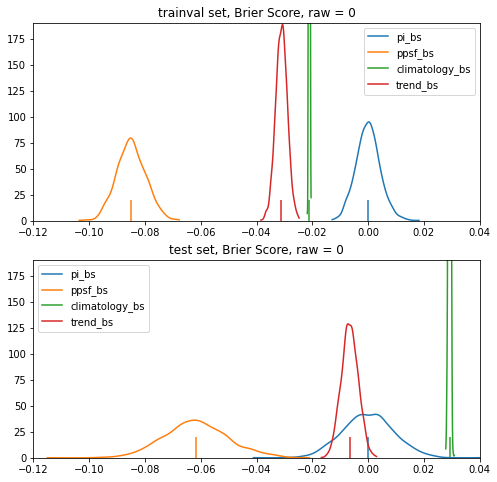

In [46]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.plot(*to_kernel_density(bszero[key]),label = key[-1])
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 20, color = im[0].get_c())
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,190)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

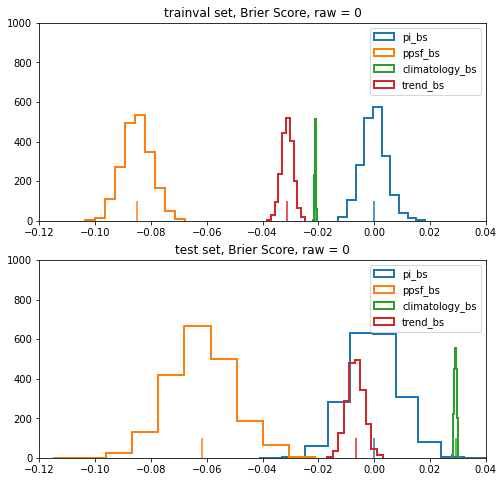

In [58]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.hist(bszero[key], label = key[-1], histtype = 'step', lw = 2)
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 100, color = im[2][0].get_edgecolor())
    #ax.set_xlim(left = -0.12, right = 0.08)
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,1000)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

In [64]:
test_only.columns.name = 'type'
trainval_only.columns.name = 'type'

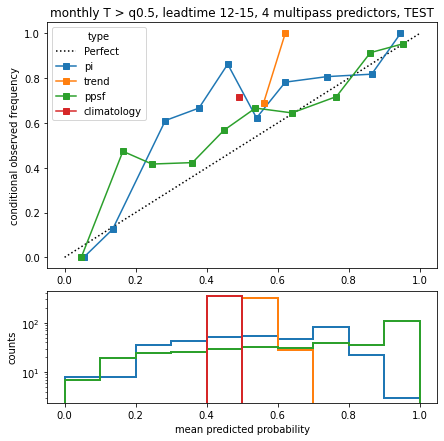

In [63]:
fig, (axrel, axhist) = reliability_plot(y_true = test_only['observation'], y_probs=test_only[['pi', 'trend','ppsf', 'climatology']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

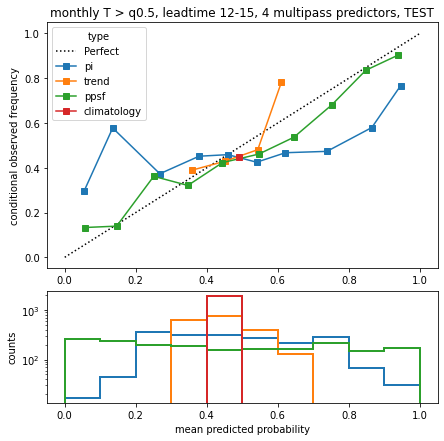

In [65]:
fig, (axrel, axhist) = reliability_plot(y_true = trainval_only['observation'], y_probs=trainval_only[['pi', 'trend','ppsf', 'climatology']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

## Broad verification
Multiple metrics, thresholds, time scales, lead times. Currently post-processed combinations are not post-processed with jmeasure input.

In [10]:
def extra_scores_and_rank(df):
    compute_kss(df)
    compute_auc(df)
    return reduce_to_ranks(df)

In [11]:
# Handle all the tganom post-processed combinations with objective sequential forward predictors.
# We will only look at test data.
timeaggs = [21,31]
quantiles = [0.5, 0.66, 0.75, 0.9]
npreds = pd.Series([4,3,4,6,4,4,4,12], index = pd.MultiIndex.from_product([timeaggs, quantiles], names = ['timeagg','quantile'])) # This is a mixture of >3% >4%
def get_tganom_predictions(timeagg: int, quantile: float):
    name = f'tg-anom_JJA_45r1_{timeagg}D-roll-mean_q{quantile}_sep12-15'
    total, test_only = build_fit_nn_model(predictandname = name, npreds = npreds.loc[(timeagg,quantile)], use_jmeasure=False)
    return test_only
results = []
for timeagg, quantile in npreds.index:
    results.append(extra_scores_and_rank(get_tganom_predictions(timeagg, quantile)))
ranks = pd.concat(results, axis = 1, keys = npreds.index)

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.5918 - brier: 0.2508 - val_loss: 0.7406 - val_accuracy: 0.5110 - val_brier: 0.2699
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6810 - accuracy: 0.6120 - brier: 0.2404 - val_loss: 0.7001 - val_accuracy: 0.5426 - val_brier: 0.2532
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6438 - accuracy: 0.6532 - brier: 0.2244 - val_loss: 0.6617 - val_accuracy: 0.5678 - val_brier: 0.2366
Epoch 4/200
41/41 [==============================] - 0s 997us/step - loss: 0.6182 - accuracy: 0.6672 - brier: 0.2130 - val_loss: 0.6397 - val_accuracy: 0.6120 - val_brier: 0.2268
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5958 - accuracy: 0.6858 - brier: 0.2034 - val_loss: 0.6165 - val_accuracy: 0.6325 - val_brier: 0.2167
Epoch 6/200
41/41 [==============================]

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.5807 - accuracy: 0.7177 - brier: 0.1940 - val_loss: 0.7044 - val_accuracy: 0.6246 - val_brier: 0.2452
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5683 - accuracy: 0.7341 - brier: 0.1874 - val_loss: 0.6855 - val_accuracy: 0.6325 - val_brier: 0.2392
Epoch 3/200
41/41 [==============================] - 0s 993us/step - loss: 0.5504 - accuracy: 0.7589 - brier: 0.1805 - val_loss: 0.6641 - val_accuracy: 0.6309 - val_brier: 0.2312
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5319 - accuracy: 0.7574 - brier: 0.1727 - val_loss: 0.6525 - val_accuracy: 0.6830 - val_brier: 0.2235
Epoch 5/200
41/41 [==============================] - 0s 998us/step - loss: 0.5162 - accuracy: 0.7776 - brier: 0.1658 - val_loss: 0.6355 - val_accuracy: 0.6688 - val_brier: 0.2171
Epoch 6/200
41/41 [=============================

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.4536 - accuracy: 0.8110 - brier: 0.1433 - val_loss: 0.6184 - val_accuracy: 0.7256 - val_brier: 0.2026
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.8219 - brier: 0.1358 - val_loss: 0.5980 - val_accuracy: 0.7303 - val_brier: 0.1974
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4012 - accuracy: 0.8375 - brier: 0.1241 - val_loss: 0.5725 - val_accuracy: 0.7413 - val_brier: 0.1884
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3718 - accuracy: 0.8390 - brier: 0.1136 - val_loss: 0.5542 - val_accuracy: 0.7524 - val_brier: 0.1818
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3510 - accuracy: 0.8460 - brier: 0.1063 - val_loss: 0.5413 - val_accuracy: 0.7287 - val_brier: 0.1778
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3343 - accuracy: 0.8554 - brier: 0.1002 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.2615 - accuracy: 0.9215 - brier: 0.0709 - val_loss: 0.2938 - val_accuracy: 0.9196 - val_brier: 0.0761
Epoch 2/200
41/41 [==============================] - 0s 981us/step - loss: 0.2502 - accuracy: 0.9199 - brier: 0.0683 - val_loss: 0.2894 - val_accuracy: 0.9180 - val_brier: 0.0749
Epoch 3/200
41/41 [==============================] - 0s 1000us/step - loss: 0.2311 - accuracy: 0.9191 - brier: 0.0641 - val_loss: 0.2796 - val_accuracy: 0.9196 - val_brier: 0.0716
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2122 - accuracy: 0.9207 - brier: 0.0592 - val_loss: 0.2709 - val_accuracy: 0.9196 - val_brier: 0.0683
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1974 - accuracy: 0.9261 - brier: 0.0550 - val_loss: 0.2742 - val_accuracy: 0.9196 - val_brier: 0.0685
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1889 - accuracy: 0.9261 - brier: 0.0537 - val_l

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.5622 - brier: 0.2574 - val_loss: 0.7758 - val_accuracy: 0.5063 - val_brier: 0.2851
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.6089 - brier: 0.2413 - val_loss: 0.7500 - val_accuracy: 0.4890 - val_brier: 0.2741
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6436 - accuracy: 0.6586 - brier: 0.2211 - val_loss: 0.7170 - val_accuracy: 0.5221 - val_brier: 0.2599
Epoch 4/200
41/41 [==============================] - 0s 995us/step - loss: 0.6066 - accuracy: 0.6967 - brier: 0.2041 - val_loss: 0.6924 - val_accuracy: 0.5536 - val_brier: 0.2492
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5834 - accuracy: 0.7224 - brier: 0.1938 - val_loss: 0.6761 - val_accuracy: 0.5789 - val_brier: 0.2425
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5695 - accuracy: 0.7263 - brier: 0.1873 - val_loss

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.5520 - accuracy: 0.7473 - brier: 0.1809 - val_loss: 0.7177 - val_accuracy: 0.6404 - val_brier: 0.2491
Epoch 2/200
41/41 [==============================] - 0s 994us/step - loss: 0.5272 - accuracy: 0.7473 - brier: 0.1726 - val_loss: 0.6989 - val_accuracy: 0.6435 - val_brier: 0.2407
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5009 - accuracy: 0.7636 - brier: 0.1633 - val_loss: 0.6942 - val_accuracy: 0.6861 - val_brier: 0.2330
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4839 - accuracy: 0.7698 - brier: 0.1569 - val_loss: 0.6754 - val_accuracy: 0.6893 - val_brier: 0.2270
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4711 - accuracy: 0.7776 - brier: 0.1525 - val_loss: 0.6674 - val_accuracy: 0.6972 - val_brier: 0.2223
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4582 - accuracy: 0.7854 - brier: 0.1477 - val_loss

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.4263 - accuracy: 0.8336 - brier: 0.1321 - val_loss: 0.6237 - val_accuracy: 0.7303 - val_brier: 0.1981
Epoch 2/200
41/41 [==============================] - 0s 990us/step - loss: 0.4075 - accuracy: 0.8383 - brier: 0.1249 - val_loss: 0.6037 - val_accuracy: 0.7603 - val_brier: 0.1917
Epoch 3/200
41/41 [==============================] - 0s 983us/step - loss: 0.3824 - accuracy: 0.8530 - brier: 0.1163 - val_loss: 0.5715 - val_accuracy: 0.7776 - val_brier: 0.1812
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3576 - accuracy: 0.8655 - brier: 0.1074 - val_loss: 0.5461 - val_accuracy: 0.7808 - val_brier: 0.1724
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3383 - accuracy: 0.8764 - brier: 0.1008 - val_loss: 0.5325 - val_accuracy: 0.7902 - val_brier: 0.1664
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3254 - accuracy: 0.8779 - brier: 0.0966 - val_lo

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.2547 - accuracy: 0.9238 - brier: 0.0679 - val_loss: 0.3192 - val_accuracy: 0.8959 - val_brier: 0.0870
Epoch 2/200
41/41 [==============================] - 0s 984us/step - loss: 0.2395 - accuracy: 0.9238 - brier: 0.0645 - val_loss: 0.3150 - val_accuracy: 0.8959 - val_brier: 0.0855
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2228 - accuracy: 0.9230 - brier: 0.0606 - val_loss: 0.3065 - val_accuracy: 0.8975 - val_brier: 0.0830
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2068 - accuracy: 0.9277 - brier: 0.0559 - val_loss: 0.3036 - val_accuracy: 0.8975 - val_brier: 0.0818
Epoch 5/200
41/41 [==============================] - 0s 994us/step - loss: 0.1904 - accuracy: 0.9362 - brier: 0.0511 - val_loss: 0.3018 - val_accuracy: 0.8991 - val_brier: 0.0808
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1752 - accuracy: 0.9417 - brier: 0.0471 - val_lo

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


<AxesSubplot:xlabel='quantile'>

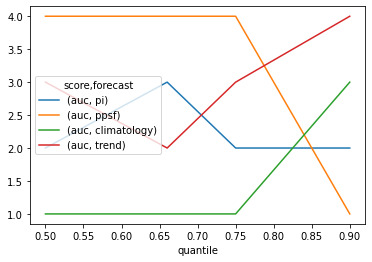

In [26]:
ranks.loc[['auc'],31].T.plot()